# Visualization of sample plane flow fields

Note: you can run this notebook at the command line with:
```bash 
jupyter nbconvert --to notebook --execute MakePlots.ipynb --output MakePlots
```

In [1]:
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

import postproamrwindsample_xarray as ppsamplexr
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Load ruamel or pyyaml as needed
try:
    import ruamel.yaml
    yaml = ruamel.yaml.YAML(typ='unsafe', pure=True)
    useruamel=True
    loaderkwargs = {'Loader':yaml.RoundTripLoader}
    dumperkwargs = {'Dumper':yaml.RoundTripDumper, 'indent':4, 'default_flow_style':False}
    Loader=yaml.load
except:
    import yaml as yaml
    useruamel=False
    loaderkwargs = {}
    dumperkwargs = {'default_flow_style':False }
    Loader=yaml.safe_load


In [3]:
# Load the inputs to visualize
yamlfile  = 'vizplanes.yaml'
verbose   = True

with open(yamlfile, 'r') as fp:
    yamldict = Loader(fp, **loaderkwargs)

In [4]:
if verbose:
    with open(yamlfile) as f: 
        print(f.read())

instantaneousplanes:
  - name: coarse XY plane
    ncfile: ../MedWS_LowTI_4kmx2km_5m/post_processing/XYdomaincoarse_103125.nc
    iters:  [1000]
    iplane: 0
    xaxis: x
    yaxis: y
    # --- optional stuff here ---
    title: 'XY Horizontal velocity T={time:0.2f}'
    plotfunc: "lambda u, v, w: np.sqrt(u**2 + v**2)"    
    clevels: 'np.linspace(0, 12, 121)'
    xlabel: 'X [m]'
    ylabel: 'Y [m]'

  - name: coarse XZ plane
    ncfile: ../MedWS_LowTI_4kmx2km_5m/post_processing/XZdomaincoarse_103125.nc
    iters:  [1000]
    iplane: 0
    xaxis: x
    yaxis: z
    # --- optional stuff here ---
    title: 'XZ Horizontal velocity T={time:0.2f}'
    plotfunc: "lambda u, v, w: np.sqrt(u**2 + v**2)"    
    clevels: 'np.linspace(0, 12, 121)'
    xlabel: 'X [m]'
    ylabel: 'Z [m]'

  - name: Wake YZ plane
    ncfile: ../MedWS_LowTI_4kmx2km_5m/post_processing/YZwake_103125.nc
    iters:  [1000]
    iplane: 5
    xaxis: y
    yaxis: z
    # --- optional stuff here ---
    group: T0_YZ_wake

## Plot the instantaneous planes

coarse XY plane
extracting iter 1000
coarse XZ plane
extracting iter 1000
Wake YZ plane
extracting iter 1000
Wake YZ plane
extracting iter 1000


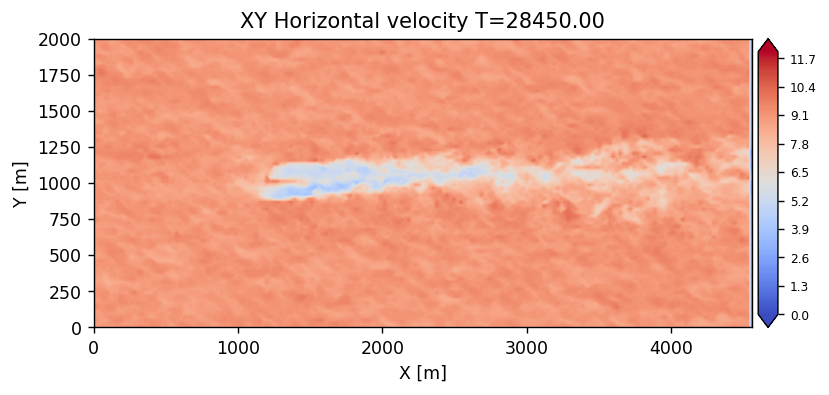

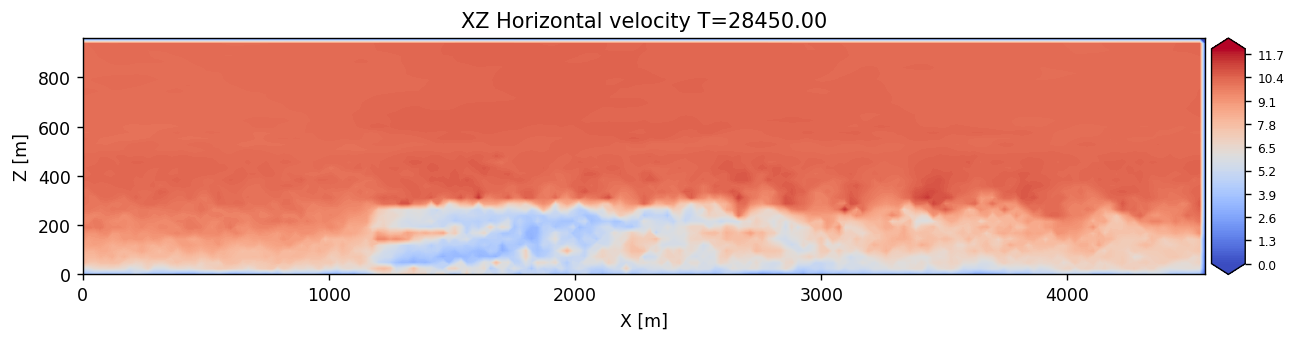

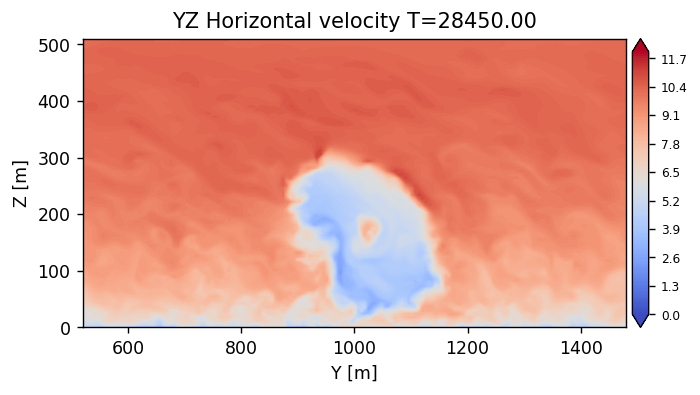

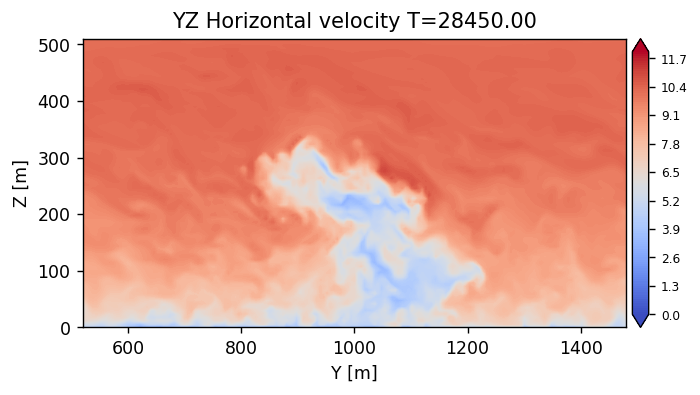

In [5]:
for plane in yamldict['instantaneousplanes']:
    print(plane['name'])
    iters    = plane['iters']
    iplane   = plane['iplane']
    ncfile   = plane['ncfile']
    xaxis    = plane['xaxis']
    yaxis    = plane['yaxis']

    # Load optional quantities
    group    = plane['group']          if 'group'   in plane else None
    varnames = plane['varnames']       if 'varnames' in plane else ['velocityx', 'velocityy', 'velocityz']
    plotfunc = eval(plane['plotfunc']) if 'plotfunc' in plane else lambda u, v, w: np.sqrt(u**2 + v**2)
    title    = plane['title']          if 'title' in plane else f'T={time:0.2f}'
    clevels  = eval(plane['clevels'])  if 'clevels' in plane else 41
    xlabel   = plane['xlabel']         if 'xlabel'  in plane else xaxis
    ylabel   = plane['ylabel']         if 'ylabel'  in plane else yaxis

    # Load the plane
    db  = ppsamplexr.getPlaneXR(ncfile, iters, varnames, groupname=group, verbose=verbose, gettimes=True)

    # Loop through each time instance and plot
    for iplot, i in enumerate(iters):
        time  = db['times'][iplot]
        
        fig, ax = plt.subplots(1,1,figsize=(12,3), dpi=125)
        #clevels=np.linspace(0, 10,101)
        plotq = plotfunc(db['velocityx'][i], db['velocityy'][i], db['velocityz'][i])
        c=plt.contourf(db[xaxis][iplane,:,:], db[yaxis][iplane,:,:], plotq[iplane, :, :], levels=clevels, cmap='coolwarm', extend='both')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        cbar=fig.colorbar(c, ax=ax, cax=cax)
        cbar.ax.tick_params(labelsize=7)

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(eval("f'{}'".format(title)))
        ax.axis('scaled')